## **Deriving Multi-layer Scaffolding of Compositional Neural Networks from existing, monolithic networks**

Contents

- [Python Imports](#scrollTo=BIBLLa2_2lQN) Python imports for the whole document
- [Introduction](#scrollTo=GaeUpA0Zc9u3) Project description & Overview
- [Tensorflow Models](#scrollTo=M32ewWRK9O82) Implementations of neural networks used throughout this document
- [Discovering Functions using SINDy](#scrollTo=SPh35ur6hgj1)
- [Applying SINDy to MNIST](#scrollTo=v5-4EKOyudwY)
- [Using Tensorflow](#scrollTo=R3gQLgM12Ipi) Quick reference and code examples for using Tensorflow
- [Maclaurin Series Approximations](#scrollTo=pmBXTRtObrAE) Older work experimenting with Maclaurin approximations.
- [Change-of-Basis Approximation Strategy](#scrollTo=pw-_Hw-ibhuE) A general approximation technique using one hidden layer and an arbitrary activation function.
- [Leveraging Depth](#scrollTo=8TojbmKi0-6k) The change-of-basis strategy is a great approximation method, but it only uses a single layer. How can the depth of the neural network be used?
- [Approximating an Arbitrary Function using Convolution](#scrollTo=K7cblEvy49nJ) A method for approximating an arbitrary function inspired by convolution.
- [Helpful Mathematical Theory](#scrollTo=wWqwROWKYaSv) Math that might be related to the direction of the project
- [Related Work](#scrollTo=FFTFQh0pijW3)

[Tensorflow Guide](https://www.tensorflow.org/guide/)


# Python Imports

These are just global imports that are used by the whole document. Run the following cell before running anything else.

In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz as gv
import sklearn.linear_model
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from IPython.display import display, Math, Latex

# Introduction

Learning systems have always been an important part of data analysis. The simplest method of learning a function from data is the linear regression, but today's deep neural networks have proven remarkably capable of learning a variety of non-linear functions. However, deep neural networks are still not well understood. While a simple linear model between two real variables is described with two parameters, deep neural networks can have hundreds of thousands of parameters that specify its precise behavior. The main benefit of increasing the number of parameters is increasing expressivity, the amount and types of functions that can be learned. But the downside of expressive learning systems is intractable resulting models.

In general, there is a trade-off between complexity and expressivity of a learning system. Complexity, also called compositionality or the opposite of tractability, refers to the number of computations the resulting trained model is expected to perform. Expressivity refers to the amount and variety of functions that can possibly be learned. Very simple classes of functions such as linear functions can be expressed concisely with a few parameters. But larger classes of functions such as higher degree polynomials require more computation and more parameters to describe generally.

Learning systems should have a balance between high expressivity and low compositionality. High expressivity is desired in learning systems because it usually translates to high accuracy of the trained model. It is more likely that a highly expressive learning system will better approximate some desired behavior. Many researchers studying the applications of machine learning care primarily about accuracy, and are therefore willing to drive up the size of their neural networks as far as hardware will allow. 

On the other hand, highly complex networks can become \textit{too} accurate in a problem known as \textit{overfitting}, meaning the network cannot extrapolate predictions to data outside the domain of the training set. In some sense finding low-complexity models for a set of data is what it means to ``understand'' the fundamental relationships among the data.

Since the importance of each trait is situationally dependent, optimal learned functions exist on a spectrum from low complexity and accuracy to high complexity and accuracy. Sometimes a sequence of increasingly more complex and accurate functions is desired instead of a single function which is fixed in these attributes. Unfortunately for neural networks, while we know that compositionality and expressivity are correlated, little else is known about this relationship. Determining if a trained network exists on this optimal spectrum is difficult. Lin et. al. \cite{lin2017why} in ``Why does deep and cheap learning work so well'' hypothesizes that most neural networks are learning functions that could be expressed using far less compositionality. He cites as evidence that most phenomena in the natural sciences can be described with low-complexity mathematical models built from a combination of a small number of simple "base functions" such as polynomials, sinusoids, and exponentials. It is possible that large sections of a trained network might be performing meaningless computations, or performing useful computations in absurdly wasteful ways.



# Related Work

The interplay between expressivity and complexity of neural networks has been studied. [Safran et. al.](https://arxiv.org/pdf/1610.09887.pdf) concluded that deep networks learned more accurately than shallow networks of similar complexity when trained to learn $L_2$-indicator functions and $L_1$ radial functions. [Chui et. al.](https://www.ams.org/journals/mcom/1994-63-208/S0025-5718-1994-1240656-2/S0025-5718-1994-1240656-2.pdf) found that deep networks are also better at localized approximation, i.e. that when a target function is modified only on a small local area of the domain, only a few neurons in a trained network need to be retrained to retain an optimal approximation. Achieving localized approximation is an important step toward developing human-understandable learning models.

Model compression attempts to reduce a neural network's complexity by pruning off pieces that have little effect on the network's behavior. [Cheng et. al.](https://arxiv.org/pdf/1710.09282.pdf) categorizes model compression techniques into four basic strategies:

1. Parameter pruning and quantization
2. Low-rank factorization
3. Transferred/compact convolutional filters
4. Knowledge distillation

Alternatively, some researchers are ditching neural networks in favor of new learning systems whose behavior is more intuitive to humans. The _fuzzy inference system_ is one such learning system.

# Searching for Analytical Models Embedded in Neural Networks

Part of the reason neural networks are hard to understand is that their mathematical representation is dissimilar to any other mathematical models we usually come across. To illustrate, consider the following function that represents some trained neural network with three hidden nodes using the standard sigmoid activation function $\sigma(x) = (1+e^{-x})^{-1}$.

$$ f(x) = 1.98\sigma(2.32x - 0.27) + 2.18\sigma(-2.20x + 6.91) + 1.81\sigma(2.37x -14.45) - 3.07 $$

This function turns out to be a very good approximation of $\sin(x)$ for $x \in [0, 2\pi]$. However, the only way we know that is from a crude analysis of the outputs such as a root-mean-square comparison.
A good question is whether or not there is some theory that formalizes, and makes intuitive, the connection between the parameters and structure of $f$ and the more commonly used sine function.

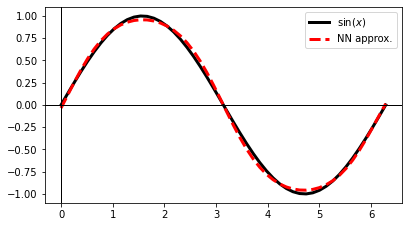

In [ ]:
def sigma(x):
  return 1.0 / (1 + math.e ** (-x))

def f(x):
  return 1.98 * sigma(2.32*x - 0.27) + 2.18*sigma(-2.20*x + 6.91) + 1.81*sigma(2.37*x - 14.45) - 3.07

x = np.linspace(0, math.pi*2)
sinx = np.sin(x)
myfunx = f(x)


plt.figure(figsize=(16/2.5, 9/2.5))
plt.plot(x, sinx, color="black", lw=3)
plt.plot(x, myfunx, linestyle="--", color="red", lw=3)
plt.axhline(color="black", lw=1); plt.axvline(color="black", lw=1)
plt.legend(["$\sin(x)$", "NN approx."])
plt.show()

To illustrate the challenge, we will contrast neural networks with polynomials which, as we will discover, have two useful properties that make them amenable to approximation. Consider polynomial functions $\mathbb{R} \rightarrow \mathbb{R}$ of the form $p(x; \pmb{\theta}) = \theta_0 + \theta_1 x + \theta_2 x^2 \cdots + \theta_d x^d$. Given data $(x_0, y_0)...(x_n, y_n)$, a unique $n$-degree polynomial that precisely models this data can be found by solving a simple linear system (assuming the $x_i$ values are all different).

$$ \pmb{0} = X\pmb{\theta} - \pmb{y} $$
$$ \begin{bmatrix} 0 \\ 0 \\ \vdots \end{bmatrix} = \begin{bmatrix} 1 & x_0 & x_0^2 & \\ 1 & x_1 & x_1^2 & \cdots \\ & \vdots \end{bmatrix} \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \end{bmatrix} - \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix}  $$

Lower-degree, best-fit polynomials can be found through a similar method called regression. For degrees less than $n$, the $X$ matrix becomes non-square and the system above will probably be unsolvable. So instead, the goal is to minimize the distance between $X\theta - \pmb{y}$ and the zero vector:

$$ \theta_{min} = \min_{\theta} || X\theta - \pmb{y} ||^2 $$

This problem can be generalized to other learning systems. Given a function $f(x;\theta)$, learning can be defined as discovering parameter values $\theta_{min}$ that minimizes the distance between the mapped inputs $f(\pmb{x}; \theta)$ and desired outputs $\pmb{y}$:

$$ \pmb{\theta}_{min} = \min_{\theta} || f(\pmb{x};\theta) - \pmb{y} ||^2 \qquad \text{(general learning problem)}$$

Importantly, we can see that for polynomials, $f$ is linear with respect to $\theta$. This means the optimization problem can be conceptualized as a problem of finding the point on an embedded hyperplane that is closest to the origin. Specifically, there are two useful properties that this entails:

1. There exists a unique function $f(\pmb{x}; \theta_{min})$ such that $||f(\pmb{x};\theta_{min}) - \pmb{y}||^2$ is locally minimal (and therefore globally minimal). This means gradient descent will converge to a single global optimum.
3. $f$ is reversible with respect to the parameters so long as the input data is well-behaved. i.e. There exists $f^{-1}$ such that $f^{-1}(\pmb{x}; f(\pmb{x}; \pmb{\theta})) = \pmb{\theta}$. This means the $\theta_{min}$ mentioned in (1) is unique, and is a consequence of the standard polynomial basis functions $\{1, x, x^2, ...\}$ being linearly independent.

Furthermore, a sequence of progressively more complex and accurate polynomials can be found by adding increasingly higher powers of the input.

Neural networks on the otherhand violate both of these properties:

1. There may exist may neural network configurations that are locally optimal which makes finding close approximations a process of trial and error.
2. The function implemented by a neural network can be characterized by many sets of parameters $\theta$. For example, $\sigma(x) = 1-\sigma(-x)$. This complicates any attempt to gain information about the network's input-output behavior by examining the network's parameters and structure.

Part of the reason neural networks don't have nice properties like this is because the feedforward layers perform function composition. Complex functions built as a sum of terms are generally much easier to understand than those built via function composition.


One way we could start is by defining a mechanized scheme for how a neural network _could_ approximate a given function, but not necessarily how the network _will_ approximate that function after training. For example, Lin points out that the operation of multipliying two real numbers $\mathbb{R}^2 \rightarrow \mathbb{R}$ can be approximated to arbitrary accuracy with a single hidden layer with four nodes:

$$ \text{mult}(x_1, x_2) = \lim_{h \rightarrow 0} \frac{\sigma(ha) + \sigma(-ha) - \sigma(hb) - \sigma(-hb)}{4 h^2 \sigma''(0)} $$

$$ \text{where}\ \ a = x_1 + x_2 \qquad b = x_1 - x_2 $$

This approximation is independent of the activation function $\sigma$ used, only requiring $\sigma''(0) \ne 0$. This multiplication operation can be used to construct neural networks that approximate any polynomial. The only additional component needed is a way to propogate values unchanged from one layer to the next, in other words, an approximation of the identity function:

$$ \text{id}(x) = x = \lim_{h \rightarrow 0} \frac{\sigma(hx) - a(0)}{h \sigma'(0)} $$

These two components, along with the native addition operation, can be used to define neural networks that approximate any multivariate polynomial. Furthermore, Taylor's theorem provides a way of constructing polynomials that approximate any differentiable curve on some domain. Consequently, given a function $g$, we can generate sequences of neural networks that approach $g$ by changing $h$ or by approximating more terms in the Taylor expansion of $g$.


Theoretically, a tool could be built that searches for these Taylor constructions in trained neural networks and identifies the original function being approximated. However, building such a tool might not be practical for the reasons described above. There are many ways of combining $\text{mult}$ and $\text{id}$ that yield the same function. For example, different compositions of multiplication often yield the same power of $x$ e.g. $\text{mult}(\text{mult}(x, x), \text{mult}(x, x)) = \text{mult}(x, \text{mult}(x, \text{mult}(x, x)))$. This means that the set of network configurations we are searching for is large and hard to describe.

Second, requiring $h$ to approach zero leads to neural networks with very large and small parameters, especially as powers of $h$ become involved. In practice, neural networks are initialized randomly with numbers roughly in the single digits, and the training rate will probably be too small to push these parameters high enough while simultaneously being too large to make subtle changes to parameters close to zero. In essence, real networks will almost certainly never learn parameters like this.

# Heuristic Approach

Instead of searching for predefined structures in a trained neural network, we could also divide the network into a composition of different "sections" and search for a simpler mathematical approximation for each section. We will call this a "heuristic approach" because the network parameters may serve as a gentle guide for discovering good approximations, but searching for concise equations will ultimately come down to trial-and-error.

Neural networks can be split up in a few ways. First, pretty much all neural networks are compositions of layers. A single layer is just a linear transformation followed by applying an activation function which is already a sufficiently concise mathematical representation, so a neural network chunk could be a few sequential layers together. Additionally, there are benefits (fewer parameters, faster training) to using networks that are not fully connected such as convolutional neural networks. This means that finding equations for intermediate nodes would be more feasible since intermediate nodes would not be functions of all the inputs, but only some of the inputs.

Once we have split the network into sections, we can use a more brute-force approach to finding an equation for each section. [Bruntun et. al.](https://arxiv.org/abs/1605.06682) describes a method called SINDy for finding sparse mathematical representations of time data. SINDy finds a best fit function of the form $f(x) = w_1 f_1(x) + w_2 f_2(x) + \cdots + w_n f_n(x) + b$ for data $(x_t, y_t)$ given functions $f_1 \dots f_n$. More precisely, it finds the coefficients $w_i$ and $b$ that optimize the following approximation:
$$ \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix} \approx \begin{bmatrix} f_0(x_0) & f_1(x_0) \\ f_0(x_1) & f_1(x_1) & \cdots \\ \vdots & \vdots \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ \vdots \end{bmatrix} + b \begin{bmatrix} 1 \\ 1 \\ \vdots \end{bmatrix}$$
The approximation above is specifically for functions $f: \mathbb{R} \rightarrow \mathbb{R}$, but it generalizes to data of arbitrary dimensions. SINDy is traditionally used to find sparse mathematical representations of dynamical systems given a set of time data.

To apply this regression-based approach to approximate neural networks, we need data generated by the neural network $(x_t, y_t)$ and a set of "base functions" $\{f_1, \dots, f_n\}$ that will become the framework of our model. We can generate data from the neural network by feeding through uniformly-distributed or random inputs in the neural network's domain of interest. For simple networks (such as $\mathbb{R} \rightarrow \mathbb{R}$ networks over a finite interval $[a,b]$), it is possible to generate data that evenly covers the entire possible input space. However, uniform coverage for larger input spaces may not be possible (such as over a set of possible images). In this case, we can trust that the training and testing data is representative of all inputs of interest.

The library functions should be chosen carefully to have a few desired properties. First, they should be linearly independent, and ideally orthogonal, so that the regression procedure will yield a single set of weights that describe the best-fit model. Second, linear combinations of the functions should be able to approximate other functions of interest. Polynomials and sinusoids are two great candidates for library functions.



## Fitting Polynomials

We will go through how a regression-based approach can be used to learn the behavior of a simple network that learns a function $f: \mathbb{R} \rightarrow \mathbb{R}$. We will assume that our domain of interest is $[-1, 1]$, so we will feed uniformly distributed numbers in that range through the network to generate data $(x_i, y_i)$. Our library functions will be the first $d$ powers of the input $\{x, x^2, \dots, x^d\}$.

Model: + 1.01x^0 + -0.99x^1 + 0.42x^2 + -0.24x^3 + 0.09x^4 + 0.06x^5


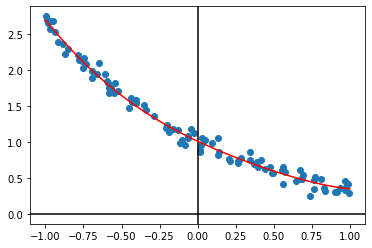

In [ ]:
# Construct data
f = lambda x: np.exp(-x)
xdata = np.random.uniform(low=-1.0, high=1.0, size=[100])
ydata = f(xdata) + np.random.normal(scale=0.08, size=[100])

# Fit a fifth-degree polynomial with regression
X = np.column_stack([xdata, xdata**2.0, xdata**3.0, xdata**4.0, xdata**5.0])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Print model
print("Model:", end="")
for c, b in zip([reg.intercept_]+list(reg.coef_), range(6)):
  print(f" + {c:.2f}x^{b}", end="")
print()

# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
x = np.linspace(-1, 1)
X = np.column_stack([x, x**2, x**3, x**4, x**5])
plt.plot(x, reg.predict(X), color="red")
plt.show()

The resulting polynomial $p$ can be compared with another analytical function $f$ is several ways. The most exact way is to consider $f$ and $p$ as vectors and compute the magnitude of the difference vector:

$$ || \pmb{p} - \pmb{f} ||^2 = \int_{-1}^{1}\left(p(x) - f(x)\right)^2\ dx $$

Instead of taking a proper integral, the difference could be approximated by sampling evenly-spaced points on the domain:

$$ \sum_{i=-N}^{N} (p(i \Delta x) - f(i \Delta x))^2 \Delta x \qquad \text{where } \Delta x = 1/N $$

You could also compare the coefficients of $p$ with the coefficients of the Maclaurin expansion of $f$ which is essentially just comparing the derivatives of the two functions at $x=0$. As an added bonus, if we ignore the zeroth derivative, we have a comparision that is invariant under the addition of a constant.

$$ \sum_{i=1}^{d} \left(p^{(i)}(0) - f^{(i)}(0)\right)^2 $$

Finally, we could compare them via cosine-similiarity which would give a comparison that is invariant under scaling by a constant.

$$ \frac{\pmb{p} \cdot \pmb{f}}{||\pmb{p}||\ ||\pmb{f}||} $$

Functions can be categorized into groups based on a small amount of information such as the first and second derivative at zero. These groups could offer suggestions about which functions might be beneficial to add to the set of library functions.

|              | $f''(0) = -1$ | $f''(0) = 0$ | $f''(0) = 1$ |
|--------------|---------------|--------------|--------------|
| $f'(0) = -1$ | $-e^x$        | $-\sin(x)$   | $e^{-x}$     |
| $f'(0) = 0$  | $\cos(x)$     |              | $-\cos(x)$   |
| $f'(0) = 1$  | $-e^{-x}$     | $\sin(x)$    | $e^x$        |

## Fitting Sinusoids

We are also looking for ways to represent function composition as a sum of simpler terms. For example, suppose we know that the data is approximately sinusoidal with angular frequency $\omega$, but we don't know the phase or amplitude. We could find the missing information by fitting a model against the two-function library $\{\sin(\omega x), \cos(\omega x)\}$ since a linear combination of these functions can be rewritten in phase-amplitude form via a simple cartesian-to-polar coordinate conversion.

$$ r \sin(\omega x + \psi) + b = w_0\sin(\omega x) + w_1\cos(\omega x) + b $$

$$ r = \sqrt{w_0^2 + w_1^2} \qquad \psi = \begin{cases} \cos^{-1}(w_0/r) & w_1 \ge 0 \\ 2\pi - \cos^{-1}(w_0/r) & w_1 < 0 \end{cases} $$

Model: 0.37sin(x) + 0.35cos(x) + 0.21
Model: 0.51sin(x + 0.76) + 0.21
Model R^2 value: 0.98


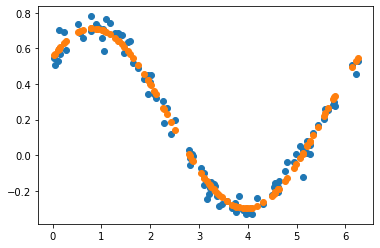

In [ ]:
# Construct data
f = lambda x: 0.5*tf.sin(x + 0.79) + 0.2
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# (x,y) -> (r,theta)
def cart2polar(x, y):
  r = math.sqrt(x**2.0 + y**2.0)
  theta = math.acos(x/r) if y >= 0.0 else 2*math.pi - math.acos(x/r)
  return [r,theta]

# Fit regression against our basis {sin(x), cos(x)}
# to get w0, w1, b
X = np.column_stack([tf.sin(xdata), tf.cos(xdata)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)
w0, w1 = reg.coef_
b = reg.intercept_

# Output model equation in two different forms
# Plot data and model predictions
print(f"Model: {w0:.2f}sin(x) + {w1:.2f}cos(x) + {b:.2f}")
r, theta = cart2polar(w0, w1)
print(f"Model: {r:.2f}sin(x + {theta:.2f}) + {b:.2f}")
print(f"Model R^2 value: {reg.score(X, ydata):.2f}")
print(plt.scatter(xdata, ydata))
print(plt.scatter(xdata, reg.predict(X)))

Alternatively, we can estimate the angular frequency of the wave using some Fourier analysis.

$$ f(x) = \sin(\omega x) $$

To find the angular frequency, we could use Fourier analysis. The Fourier transform of a pure sine wave will be zero everywhere except for at the frequency of the wave:

$$ \hat{f}(\xi) = \int_{-\infty}^{\infty} f(t)\cos(2\pi\xi t)\ dt - i\int_{-\infty}^{\infty} f(t)\sin(2\pi\xi t)\ dt $$

We are not interested in calculating values of the Fourier transform, but only in discovering frequencies where $\hat{f}$ is large. This means we can integrate on a finite interval instead of over all real numbers:

$$ g(\xi) = \int_{0}^{L} f(t)\cos(2\pi\xi t)\ dt - i\int_{0}^{L} f(t)\sin(2\pi\xi t)\ dt $$

The function $g$ converges to $\hat{f}$ as the range of the integration increases. But importantly, even if the range is small, the value of $n$ that maximizes $g$ should be approximately the same $n$ value that maximizes $\hat{f}$.

$$ \max_{\xi}|g(\xi)| \approx \max_{\xi}|\hat{f}(\xi)| $$

Now we have the correspondence:

$$ g\left( \frac{n}{L} \right) = \frac{L}{2} (a_n - ib_n) $$

where $a_n$ and $b_n$ are the coefficients of the Fourier series expansion of $f$:

$$ f(x) = a_0 + \sum_{n=1}^{\infty} \left[ a_n\cos\left(\frac{2\pi nx}{L}\right) + b_n\sin\left(\frac{2\pi nx}{L}\right) \right] $$

$$ a_n = \frac{2}{L}\int_0^{L} f(x)\cos\left( \frac{2\pi nx}{L} \right)\ dx $$
$$ b_n = \frac{2}{L}\int_0^{L} f(x)\sin\left( \frac{2\pi nx}{L} \right)\ dx $$

So, we want to find

$$ \max_{\xi} \left| g\left(\xi\right)\right| = \frac{L}{2}(a_{L\xi}^2 + b_{L\xi}^2) $$


Closest frequency: 2.0


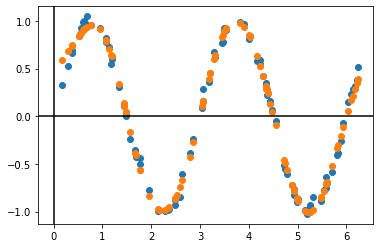

In [ ]:
# Construct data
f = lambda x: np.sin(2.1*x)
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# Fit a regression using a basis of sinusoids
X = np.column_stack([np.sin(n*0.5*xdata) for n in range(1,11)]\
                  + [np.cos(n*0.5*xdata) for n in range(1, 11)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Find largest coefficient
i_of_largest_coef = np.argmax(reg.coef_)
print("Closest frequency:", 0.5*(i_of_largest_coef+1))

# Estimate the frequency


# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
plt.scatter(xdata, reg.predict(X))
plt.show()

# Image Classification

Moving from simple $\mathbb{R} \rightarrow \mathbb{R}$ functions to a more practical scenario comes with challenges. We will discuss these challenges and some possible solutions by learning equations for image classification using the MNIST dataset. A function trained on the MNIST dataset will have the form $\mathbb{R}^{784} \rightarrow \mathbb{R}^{10}$ mapping 28-by-28-pixel images into an activation value for each of the ten possible digits '0' through '9'. We will learn this function using a 3-layer fully-connected network with output dimensions 183, 57, and 10. These numbers were chosen to have approximately the same ratio between consecutive layers ($784/183 \approx 183/57 \approx 57/10$). We will also only consider one of the ten outputs at a time.

Data will be gathered by feeding the 10,000 MNIST test images through the trained network and collecting the output values corresponding to a single digit (usually '0'). This was considered preferable to feeding through randomly generated input data.

In [2]:
def constructModel():
  """Builds a 4-layer neural network, trains it on MNIST data,
  prints information, saves the model to a file, returns model"""
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(60000, 784).astype("float32") / 255
  x_test = x_test.reshape(10000, 784).astype("float32") / 255

  # Build and compile model
  inputs = keras.Input(shape=(784,))
  hiddl1 = keras.layers.Dense(183, activation="relu")(inputs)
  hiddl2 = keras.layers.Dense(57, activation="relu")(hiddl1)
  outputs = keras.layers.Dense(10, activation="relu")(hiddl2)
  model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
  model.summary()
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=keras.optimizers.RMSprop(),
      metrics=["accuracy"],
  )

  # Fit data, print test results
  model.fit(x_train, y_train, batch_size=64, epochs=3, validation_split=0.2)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  model.save("mnist_model.h5")
  print("Saved model to mnist_model.h5")
  return model

def getDataForDigit(digit, model=None):
  """
  Returns (x_data, y_data)
  x_data: numpy array (10000, 784), the pixel data of the MNIST test images
  y_data: numpy array (10000,), the output of the neural network for the
          given digit.
  If model is `None` then it is loaded from file
  """
  _, (x_data, _) = keras.datasets.mnist.load_data()
  x_data = x_data.reshape(10000, 784).astype("float32") / 255
  if not model:
    model = keras.models.load_model("mnist_model.h5")
  y_data = model.predict(x_data)
  y_data = np.array([y[digit] for y in y_data])
  return x_data, y_data

def linearRegression(X, y_data):
  """Returns the regression object that results from
  fitting the given data"""
  reg = sklearn.linear_model.LinearRegression()
  reg.fit(X, y_data)
  return reg

def showAsImages(pixeldatalist, titles=None):
  """
  Displays `len(pixeldatalist)` images, each 28x28 pixels
  """
  pixeldatalist = [np.array(item) for item in pixeldatalist]
  f, axes = plt.subplots(1, len(pixeldatalist))
  for i, axis in enumerate(axes):
    axis.imshow(pixeldatalist[i].reshape(28, 28), cmap="gray")
    if titles:
      axis.set_title(titles[i])
  f.set_size_inches(8, 8)
  plt.show()

In [3]:
_, (x_data, _) = keras.datasets.mnist.load_data()
x_data = x_data.reshape(10000, 784).astype("float32") / 255
y_data = model.predict(x_data)
y_data = np.array([y[8] for y in y_data])
y_data[0:20]

NameError: name 'model' is not defined

In [4]:
model = constructModel()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 183)               143655    
_________________________________________________________________
dense_1 (Dense)              (None, 57)                10488     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                580       
Total params: 154,723
Trainable params: 154,723
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
750/750 [==============================] - 3s 3ms/step - loss: 0.7627 - accuracy: 0.7492 - val_loss: 0.3864 - val_accuracy: 0.8571
Epoch 2/3
750/750 [==============================] - 2s 3ms/step - loss: 0.3653 - accuracy: 0.8639 - val_l

## A Linear Model

To start off, we will simply fit a linear model to the value of the '0' node. The result is 784 learned weights that indicate how the zero activation varies linearly with each pixel. These weights are displayed below in a 28-by-28 grid. Black indicates a negative weight while white indicates a positive weight.

We can evaluate the accuracy of our model using the coefficient of determination for the regression ($R^2$). We can see that even a linear model yields surprisingly high $R^2$ values around 0.80. 

Regression results for digit '0'



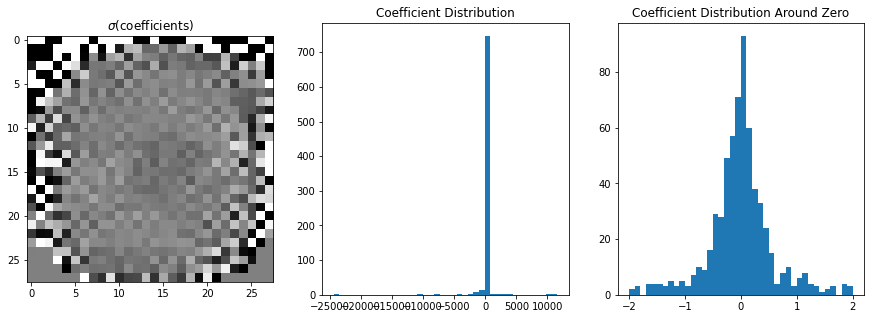


Intercept: 1.7313
Lowest weight -24370.01 is at pixel 670
R^2: 0.8153
Proportion of coefficients between -1 and 1: 634


In [5]:
digit = 0

x_data, y_data = getDataForDigit(digit)
reg = linearRegression(x_data, y_data)

print(f"Regression results for digit '{digit}'\n")

f, axes = plt.subplots(1, 3)
axes[0].imshow(tf.nn.sigmoid(reg.coef_.reshape(28, 28)), cmap="gray")
axes[0].set_title(r"$\sigma$(coefficients)")
axes[1].set_title(r"Coefficient Distribution")
axes[1].hist(reg.coef_, bins=40)
axes[2].hist(reg.coef_, bins=40, range=(-2, 2))
axes[2].set_title(r"Coefficient Distribution Around Zero")
f.set_size_inches(15, 5)
plt.show()

print(f"\nIntercept: {reg.intercept_:.4f}")
print(f"Lowest weight {reg.coef_.min():.2f} is at pixel {reg.coef_.argmin()}")
print(f"R^2: {reg.score(x_data, y_data):.4f}")
print("Proportion of coefficients between -1 and 1:", np.count_nonzero(np.abs(reg.coef_) <= 2))

## Low-Variance Pruning

Since 784 input dimensions is a little unweildy, we need a way of prioritizing inputs. One strategy is to prioritize based on the input's **variance** in the dataset. For the MNIST images, most of the pixels along the edge of the image are black no matter which image we look at, so these pixels have a variance of zero and should not be included in our mathematical model.

It makes sense to extend this reasoning the other way. If we are building a progressively more complex equation, we should add the pixels with the **highest variance first**

This could possibly be extended to **terms with high variance** instead of just input variables.

Pixel averages and variances over all test images


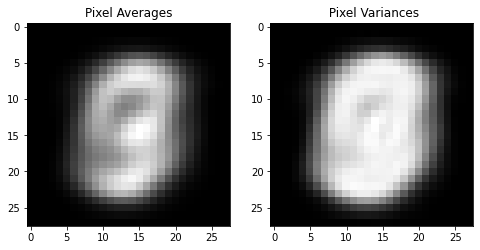

Max pixel variance is 0.2009 at pixel 378
Max pixel average is 0.5606 at pixel 435


In [ ]:
x_data, _ = getDataForDigit(0)

pixel_averages = np.average(x_data, axis=0)
pixel_variances = np.var(x_data, axis=0)

print("Pixel averages and variances over all test images")
showAsImages([pixel_averages, pixel_variances], ["Pixel Averages", " Pixel Variances"])

print(f"Max pixel variance is {pixel_variances.max():.4f} at pixel {pixel_variances.argmax()}")
print(f"Max pixel average is {pixel_averages.max():.4f} at pixel {pixel_averages.argmax()}")

Show how linear model gets better as more pixels are added.
Pixels with highest variance are added first.


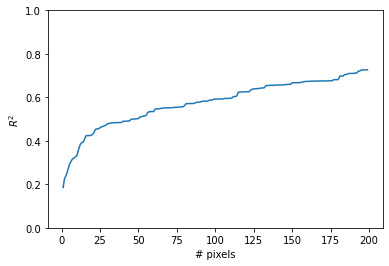

In [ ]:
x_data, y_data = getDataForDigit(0)

pixel_variances = sorted(enumerate(np.average(x_data, axis=0)), key=lambda pair: pair[1], reverse=True)

r2vals = []
for numpixtoinclude in range(1, 200):
  includeinreg = [x_data[:,pair[0]] for pair in pixel_variances[:numpixtoinclude]]
  X = np.column_stack(includeinreg)
  reg = linearRegression(X, y_data)
  r2vals.append(reg.score(X, y_data))

print("Show how linear model gets better as more pixels are added.")
print("Pixels with highest variance are added first.")
axis = plt.figure().add_subplot(111)
axis.set_ylim([0, 1])
axis.plot(range(1, 200), r2vals)
axis.set_xlabel("# pixels")
axis.set_ylabel("$R^2$")
plt.show()


## Discriminatory Pixels

For image processing, a pixel with high variance accross the input space doesn't necessarily mean that it can be used to discriminate between classes of images. In fact, useful pixels will have low variance across the images in any particular class, but high variance across the entire set of images. The code below displays the average and variance of each pixel across all the images of the class '0'. Notice the loop of darker pixels in the variance image. These pixels are most likely to be white given the image depicts a '0'.

Pixel averages and variances over all images CLASSIFIED as 0
by the neural network:


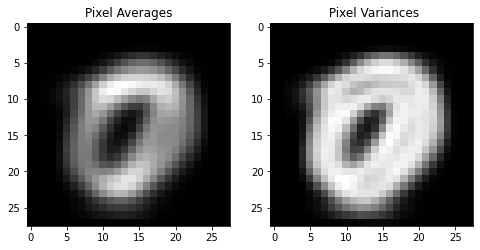

Max pixel variance is 0.2063 at pixel 464
Max pixel average is 0.7121 at pixel 237


In [6]:
_, (x_data, _) = keras.datasets.mnist.load_data()
x_data = x_data.reshape(10000, 784).astype("float32") / 255
model = keras.models.load_model("mnist_model.h5")
y_data = model.predict(x_data)
y_data = np.array([y.argmax() for y in y_data])

x_data_0 = []
for inp, oup in zip(x_data, y_data):
  if oup == 0:
    x_data_0.append(inp)

pixel_averages = np.average(x_data_0, axis=0)
pixel_variances = np.var(x_data_0, axis=0)

print("Pixel averages and variances over all images CLASSIFIED as 0")
print("by the neural network:")
showAsImages([pixel_averages, pixel_variances], ["Pixel Averages", " Pixel Variances"])

print(f"Max pixel variance is {pixel_variances.max():.4f} at pixel {pixel_variances.argmax()}")
print(f"Max pixel average is {pixel_averages.max():.4f} at pixel {pixel_averages.argmax()}")

## Evolutionary Equation Learning

While a linear model is a good starting point, including some non-linear terms should allow for more accurate models. We will limit our linear model to the ten highest-varying inputs and experiment with adding quadratic terms.

If a set of base functions is chosen properly, we can extract meaningful information about the computation being performed by a neural network. However, finding the best set of base functions is no easy task. Polynomials are great for approximating general functions, but what if the neural network is actually calculating an exponential or periodic function, or combinations of functions?

Here we will use an iterative process for refining the set of base functions:

* $\mathcal{B} =$ initial base terms
* repeat:
  1. $\theta \leftarrow$ parameters from fitting to functions $\mathcal{B}$
  2. remove insignificant terms from $\mathcal{B}$
  3. add new possibly significant terms to $\mathcal{B}$

The third step is the most difficult. To start, we could just naively consider every basis function to be possibly significant. We could start with $B = \{x_1, x_2, ..., x_{784}\}$ and find a linear fit, eliminate terms with small coefficients, then add $\{x_1^2, x_1 x_2, x_1 x_3, ..., x_1 x_{784}\}$, and so on. However, it would be nice to have a way of determining which basis functions are most likely to be significant by using the model from the previous iteration.

**Idea 1**: _the functions in $B$ should only be compositions of basis functions from the $B$ of the previous iteration._

For example, we could start by fitting a linear regression against $B=\{x_1, x_2, x_3, x_4\}$. Suppose we find out that the coefficients on $x_3$ and $x_4$ are negligible. Then our next set of basis functions could be $B = \{x_1, x_2, x_1^2, x_2^2, x_1 x_2\}$ only constructed from the previously significant functions. The problem is that if the coefficient on $x_3$ is close to zero, that doesn't mean $x_3$ is unimportant, it just means that _on average_, the output doesn't change with respect to $x_3$.

**Idea 2**: _find ways of representing compound functions using sums of other functions_

For example, a function of the form $a\cos(x) + b\sin(x)$ can always be rewritten in the form $r\sin(x + \psi)$ via a simple cartesian->polar coordinate conversion. Fourier series and Taylor series are also techniques for doing this, but present their own challenges:
* While there are algorithms to convert functions into polynomials, sinusoids, etc (Maclaurin series, Fourier analysis), there are not general algorithms to convert back to the original functions.

In [7]:
class Term:
  def __init__(self, name, data, degree):
    self._name = name
    self._data = data
    self._degree = degree
    self._coef = None
    self._var = None
  def __lt__(self, other):
    return self._coef < other._coef
  def __eq__(self, other):
    return self._coef == other._coef
  def __repr__(self):
    if self._coef == None:
      return f"\\_{self._name}"
    return f"{self._coef:.2f}{self._name}"
  def __mul__(self, other):
    return Term(self._name+other._name, self._data*other._data, self._degree + other._degree)
  def getVariance(self):
    if self._var != None: return self._var
    self._var = np.var(self._data)
    return self._var
  def getCoefMag(self):
    return np.abs(self._coef)
  def getCoef(self):
    return self._coef

class Equation:
  def __init__(self, terms=None):
    self._terms = terms.copy() if terms else []
    self.rsquared_ = None
    self.intercept_ = None
  def fitTerms(self, y_data):
    X = np.column_stack([t._data for t in self._terms])
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X, y_data)
    for i, c in enumerate(reg.coef_):
      self._terms[i]._coef = c
    self.rsquared_ = reg.score(X, y_data)
    self.intercept_ = reg.intercept_
  def getR2(self):
    return self.rsquared_
  def pruneByVariance(self, remaining):
    self._terms = sorted(eq._terms, key=Term.getVariance, reverse=True)[:remaining]
  def pruneByCoef(self, remaining):
    self._terms.sort(key=Term.getCoefMag, reverse=True)
    self._terms = self._terms[:remaining]
  def pruneByVarTimesCoef(self, remaining):
    keyFunc = lambda t: t.getCoefMag()*t.getVariance()
    self._terms = sorted(eq._terms, key=keyFunc, reverse=True)[:remaining]
  def elimByVarThreshold(self, threshold):
    self._terms = list(filter(lambda x: x.getVariance() >= threshold, self._terms))
  def sortByVariance(self, descending=True):
    self._terms.sort(key=Term.getVariance, reverse=descending)
  def sortByCoef(self, descending=True):
    self._terms.sort(key=Term.getCoefMag, reverse=descending)
  def sortByVarTimesCoef(self, descending=True):
    keyFunc = lambda t: t.getCoefMag()*t.getVariance()
    self._terms.sort(key=keyFunc, reverse=descending)
  def sortByVIC(self, descending=True):
    keyFunc = lambda t: t.getVariance() / (t.getCoefMag() + 1)
    self._terms.sort(key=keyFunc, reverse=descending)
  def display(self):
    display(Latex(" + ".join([t.__repr__() for t in self._terms])))
  def mutate(self):
    retEq = Equation(self._terms.copy())
    retEq.sortByVIC()
    alpha = 1 - math.pow(1-0.99, 1/(len(retEq._terms)+1))  # prob of stopping for each index
    ix = 0
    while random.random() > alpha:
      ix += 1
      if ix >= len(retEq._terms): return retEq
    for t in random.sample(retEq._terms, int(len(retEq._terms) * 0.2) + 1):
      newt = t * retEq._terms[ix]
      if newt._degree <= 5:
        retEq._terms.append(newt)
        
    return retEq

In [ ]:
# Equation with quadratics and 10 terms
x_data, y_data = getDataForDigit(0)

# Get top linear terms
eq = Equation()
for i, singlepixeldata in enumerate(x_data.T):
  eq._terms.append(Term("x_{%d}" % i, singlepixeldata, 1))
eq.fitTerms(y_data)
eq.pruneByVariance(10)
eq.fitTerms(y_data)
eq.display()
print("\n", eq.rsquared_, "\n")
#eq.pruneByVariance(5)

# Add quadratic terms (build from the linear terms)
quadTerms = []
for i, t1 in enumerate(eq._terms):
  for t2 in eq._terms[i:]:
    quadTerms.append(t1*t2)
eq._terms += quadTerms

eq.fitTerms(y_data)
eq.pruneByCoef(10)
eq.fitTerms(y_data)
eq.display()
print("\n", eq.rsquared_)

<IPython.core.display.Latex object>


 0.0006133152877434433 



<IPython.core.display.Latex object>


 0.0007010374405280739


## VIC 

VIC (Variance times Inverse Coefficient) represents the likelihood that a term is significant, just not in its current form, so maybe combining it with other terms will increase the chances of it being significant.

$$ \text{VIC}(t) = \frac{\text{var}(t)}{\text{coef}(t)} $$

|           | high var  | low var |
|----------:|-----------|---------|
| high coef | keep      | elim    |
| low coef  | recombine | elim    |

Algorithm:

* repeat:
  * Sort by VIC
  * Remove high VIC terms
  * Recombine high VIC terms and add them back
  * Prune by Variance

In [8]:
def constructModel():
  """Builds a 4-layer neural network, trains it on MNIST data,
  prints information, saves the model to a file, returns model"""
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(60000, 784).astype("float32") / 255
  x_test = x_test.reshape(10000, 784).astype("float32") / 255

  # Build and compile model
  inputs = keras.Input(shape=(784,))
  hiddl1 = keras.layers.Dense(183, activation="relu")(inputs)
  hiddl2 = keras.layers.Dense(57, activation="relu")(hiddl1)
  outputs = keras.layers.Dense(10, activation="relu")(hiddl2)
  model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
  model.summary()
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=keras.optimizers.RMSprop(),
      metrics=["accuracy"],
  )

  # Fit data, print test results
  model.fit(x_train, y_train, batch_size=64, epochs=3, validation_split=0.2)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  model.save("mnist_model.h5")
  print("Saved model to mnist_model.h5")
  return model

In [ ]:
# Construct a 4-layer fully connected neural network and
# train the model to classify MNIST digits.
model = constructModel()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 183)               143655    
_________________________________________________________________
dense_1 (Dense)              (None, 57)                10488     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                580       
Total params: 154,723
Trainable params: 154,723
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
750/750 [==============================] - 5s 6ms/step - loss: 0.8004 - accuracy: 0.7844 - val_loss: 0.3841 - val_accuracy: 0.9409
Epoch 2/3
750/750 [==============================] - 4s 5ms/step - loss: 0.3520 - accuracy: 0.9548 - val_l

In [9]:
# Evolutionary Equation Learning Algorithm

n = 10         # number of equations to work with at once
numterms = 10  # number of terms in each equation

x_data, y_data = getDataForDigit(0, model=model)

# Gather pixels with a variance above the threshold 0.1
sigterms = Equation()
for i, singlepixeldata in enumerate(x_data.T):
  sigterms._terms.append(Term("x_{%d}" % i, singlepixeldata, 1))
sigterms.elimByVarThreshold(0.1)
sigterms.sortByVariance()

# Build initial linear equations from highest-varying pixels
eqs = []
for i in range(n):
  neweq = Equation(sigterms._terms[:numterms])
  neweq.fitTerms(y_data)
  eqs.append(neweq)

# Evolutionary learning loop
lintermix = numterms    # next linear term to add
iterations = 0          # number of iterations
while lintermix < len(sigterms._terms):
  iterations += 1

  # Mutation: Add the next highest-varying linear term
  for eq in eqs:
    eq._terms.append(sigterms._terms[lintermix])
    eq.fitTerms(y_data)
    eq.pruneByCoef(numterms)
    eq.fitTerms(y_data)
  lintermix += 1

  # Mutation: Recombination of a single low-VIC term
  for eq in tuple(eqs):
    neweq = eq.mutate()
    neweq.fitTerms(y_data)
    neweq.pruneByCoef(numterms)
    neweq.fitTerms(y_data)
    eqs.append(neweq)

  # Selection: remove equations with low R^2 value
  eqs.sort(key=Equation.getR2, reverse=True)
  eqs = eqs[0:n]

  # Evaluation & Display
  averageR2 = sum(map(Equation.getR2, eqs)) / len(eqs)
  if iterations % 10 == 0 or iterations < 10:
    print("Iterations: {}, R^2: {}".format(iterations, averageR2))

print("----- Final equation -------")
eqs.sort(key=Equation.getR2, reverse=True)
eqs[0].display()
print("R^2:", eqs[0].getR2())

Iterations: 1, R^2: 0.4776507058407578
Iterations: 2, R^2: 0.5197914225984966
Iterations: 3, R^2: 0.5361806974389492
Iterations: 4, R^2: 0.5475975371326502
Iterations: 5, R^2: 0.5630084051375925
Iterations: 6, R^2: 0.5797643554566219
Iterations: 7, R^2: 0.5842705768926446
Iterations: 8, R^2: 0.5940954590968097
Iterations: 9, R^2: 0.6016903069047493
Iterations: 10, R^2: 0.604656694809732
Iterations: 20, R^2: 0.6173228010889436
Iterations: 30, R^2: 0.6173227990602274
Iterations: 40, R^2: 0.6173227996507219
Iterations: 50, R^2: 0.6173227983167993
Iterations: 60, R^2: 0.6173227991034491
Iterations: 70, R^2: 0.6173228005114305
Iterations: 80, R^2: 0.6173228013359816
Iterations: 90, R^2: 0.6173228023055343
Iterations: 100, R^2: 0.6173228009115039
Iterations: 110, R^2: 0.6173227965985945
Iterations: 120, R^2: 0.6173228009115039
Iterations: 130, R^2: 0.6173227989717921
Iterations: 140, R^2: 0.6173228032312253
Iterations: 150, R^2: 0.6173228009659968
Iterations: 160, R^2: 0.6173227981595925
Ite

<IPython.core.display.Latex object>

R^2: 0.7210257825270434


# CNNs

* **filter** -- a small matrix (like 3x3 or 5x5) of coeffients.
* **feature map** -- the result of convolving an image with a filter.

Usually, networks are constructed by composing pairs of layers (a convolutional layer followed by a max-pooling layer). This converts a large image into a smaller image. Why is this used instead of just increasing the stride of the convolutional layer? Because a convolutional layer with a large stride has a "blurring effect". A conv layer with a very small stride can pinpoint exactly where the important features are (by finding local maxima). After max-pooling, the resulting image holds information about what sections of the image contain the feature, not how about how well each section of the image matches the feature exactly.

In [ ]:
# "recommended network" from https://keras.io/examples/vision/mnist_convnet/
def constructModel():
  """Builds a 4-layer neural network, trains it on MNIST data,
  prints information, saves the model to a file, returns model"""
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
  x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)

  # Build and compile model
  model = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          keras.layers.MaxPooling2D(pool_size=(2, 2)),
          keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          keras.layers.MaxPooling2D(pool_size=(2, 2)),
          keras.layers.Flatten(),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(10, activation="softmax"),
      ]
  )
  model.summary()
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  # Fit data, print test results
  model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  model.save("mnist_conv_model.h5")
  print("Saved model to mnist_model.h5")
  return model

def getDataForDigit(digit, model=None):
  """
  Returns (x_data, y_data)
  x_data: numpy array (10000, 784)
  y_data: numpy array (10000,)
  If model is `None` then it is loaded from file
  """
  _, (x_data, _) = keras.datasets.mnist.load_data()
  x_data = x_data.reshape(10000, 28, 28, 1).astype("float32") / 255
  if not model:
    model = keras.models.load_model("mnist_conv_model.h5")
  y_data = model.predict(x_data)
  y_data = np.array([y[digit] for y in y_data])
  x_data = x_data.reshape(10000, 28, 28)
  return x_data, y_data

def showAsImages(pixeldatalist, dims=(28, 28), titles=None):
  """
  Displays `len(pixeldatalist)` images, each 28x28 pixels
  """
  pixeldatalist = [np.array(item) for item in pixeldatalist]
  f, axes = plt.subplots(1, len(pixeldatalist))
  for i, axis in enumerate(axes):
    axis.imshow(pixeldatalist[i].reshape(dims), cmap="gray")
    if titles:
      axis.set_title(titles[i])
  f.set_size_inches(8, 8)
  plt.show()

In [ ]:
# testing my own simpler convnet
def constructModel():
  """Builds a 4-layer neural network, trains it on MNIST data,
  prints information, saves the model to a file, returns model"""
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
  x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)

  # Build and compile model
  model = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          #keras.layers.AveragePooling2D(pool_size=(4, 4)),
          keras.layers.Conv2D(1, kernel_size=(4, 4), activation="relu"),
          keras.layers.MaxPool2D(pool_size=(4, 4)),
          keras.layers.Flatten(),
          keras.layers.Dense(10, activation="softmax"),
      ]
  )
  model.summary()
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  # Fit data, print test results
  model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
  test_scores = model.evaluate(x_test, y_test, verbose=2)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])
  model.save("mnist_conv_model.h5")
  print("Saved model to mnist_model.h5")
  return model

In [ ]:
model = constructModel()

11493376/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 1)         17        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                370       
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
422/422 [==============================] - 11s 24ms/step - loss: 1.9891 - accuracy: 0.2666 - val_loss: 0.7360 - val_accuracy: 0.7785
Epoch 2/5
422/422 [=============================

Here, we are using a simple convolutional neural network with the following layers:

* A Conv2D layer with 4x4 kernel to produce a 25x25 image
* Max-pooling with 4x4 pool-size to produce a 6x6 image
* A dense layer to produce a 10-element vector

The weights for the Conv2D layer's filter:
Largest weight: 0.9508198 occurs at 9
Smallest weight: -0.0348124 occurs at 15


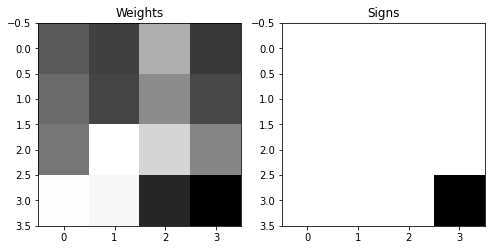

In [ ]:
filter_weights = model.get_weights()[0].reshape(4, 4)
print("The weights for the Conv2D layer's filter:")
print("Largest weight:", filter_weights.max(), "occurs at", filter_weights.argmax())
print("Smallest weight:", filter_weights.min(), "occurs at", filter_weights.argmin())
filter_weights_signs = np.sign(filter_weights)
showAsImages([filter_weights, filter_weights_signs], dims=(4, 4), titles=["Weights", "Signs"])

Weights for the dense layer for the '0' activation


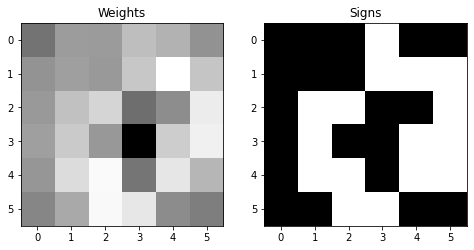

In [ ]:
print("Weights for the dense layer for the '0' activation")
digit = 0
dense_weights = model.get_weights()[2][:,digit].reshape(6, 6)
dense_weights_signs = np.sign(dense_weights)
showAsImages([dense_weights, dense_weights_signs], dims=(6,6), titles=["Weights", "Signs"])

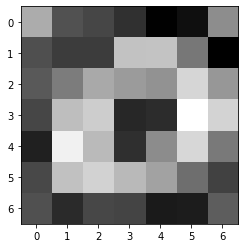

In [ ]:
# Network used:
#   average pooling with pool_size=(4,4)
#   flatten from 7x7 into 49
#   dense 49 -> 10 layer with softmax activation
# This image shows the 49 weights of the dense layer for the '0' output
# and you can see the "0".
zero_weights = model.get_weights()[0]
plt.imshow(zero_weights[:,0].reshape(7, 7), cmap="gray")

# Conclusion

Neural networks are difficult learning systems to understand because of the mathematical constructs that make them up. This can cause unpredictable behavior when the neural network is given data that lies outside of the domain on which it was trained.

More exploration of equation-learning could be done. Learning systems that learn equations could possibly replace deep neural networks for a lot of machine learning tasks.

---

# Using Tensorflow

An brief overview of tensor math and learning models in the Tensorflow library descibed with lots of code examples.

In [ ]:
# generating simple test data

f = open("sin_data.csv", "w")
f.write("x,sin(x)\n")
for i in range(200):
  x = random.random()*2*math.pi
  v = math.sin(x)
  f.write(str(x)+","+str(v)+"\n")
f.close()

In [ ]:
# example loading CSV file into a pandas dataframe
sin_dataframe = pd.read_csv("sin_data.csv", sep=",")  # type is pd.DataFrame
sin_dataframe.head(3)   # returns a new dataframe with only first 3 rows

,x,sin(x)
0,2.438507,0.646574
1,4.413438,-0.955646
2,1.221277,0.939538


## Tensor Math

The primary objects that Tensorflow provides are tensors -- a generalization of scalars, vectors, and matrices to numerical arrays of arbitrary dimension. Tensors have the following properties:

* **dimension**: the number of layers of nested lists needed to represent the tensor (e.g. a vector is a 1-D tensor, a matrix is a 2-D tensor).
* **shape**: a list of numbers describing the "length" of the tensor in each direction (e.g. matrices all have shape (nrows, ncols)).

In [ ]:
# Tensors
t0 = tf.constant(4)   # a rank-0 tensor (i.e. a scalar)
t1 = tf.constant([1,2,3])   # a rank-1 tensor (i.e. a vector)
t2 = tf.constant([[1,2,3], [4,5,6], [7,8,9]])   # a rank-2 tensor (i.e. a matrix)

# constructing simple tensors
t = tf.zeros([3,2])   # a 3x2 tensor filled with zeros
t = tf.random.uniform([3,2], minval=0, maxval=1)
t = tf.random.normal([3,2], mean=5, stddev=2)
t = tf.eye(4)   # 4x4 identity matrix

t = tf.constant([[1,2], [3,4]], dtype=tf.float32)  # manually specify element type

a = np.array(t)   # convert Tensor to numpy array
t = tf.constant(a)  # convert numpy array to Tensor

# Tensor operations
ta = tf.constant([[1,2],[3,4]], dtype=tf.float32)
tb = tf.constant([[5,6],[7,8]], dtype=tf.float32)
t = ta + tb   # element-wise addition
t = ta * tb   # element-wise multiplication
t = ta @ tb   # "matrix" multiplication
t = tf.reduce_max(ta)   # largest value
t = tf.argmax(ta)       # index of largest value
b = ta == tb            # comparison operators are element-wise

# Tensor shape, rank, dimension, size
t = tf.constant([[1,2,3],[4,5,6]])
shape = t.shape     # [2, 3]
anelem = t[0,0]     # indexing (returns a Tensor)
anelem = t[0][0]    # also indexing
t = tf.reshape(t, (3, 2))   # does not shuffle elements in memory, so cheap


## Automatic Differentiation

A _gradient_ is an operation on a scalar-valued function with a tensor input $f: T \rightarrow \mathbb{R}$. The result of calculating the gradient of a function $\nabla f$ is a tensor of same shape as the input. A _Jacobian_ is the generalization of the gradient to tensor-valued functions. If $f: T_{d_1 \times \dots \times d_n} \rightarrow T_{\delta_1 \times \dots \times \delta_m}$, then $\mathbf{J} f: T_{\delta_1 \times \dots \times \delta_m \times d_1 \times \dots \times d_n}$.

In [ ]:
# Automatic Differentiation & Variables

x = tf.Variable([[1],[2],[3]], name="x", dtype=tf.float32)

# a "tape" is needed to store automatic differentiation values
# call GradientTape with persistent=True if you want to calculate multiple
# gradients or jacobians
with tf.GradientTape() as tape:
  y = tf.constant([[1,1,1], [5,1,0]], dtype=tf.float32) @ x

print(y)
j = tape.jacobian(y, x)   # j[output indeces, input indices]

# j[output indeces][input indices] is the derivative
# of output[output indeces] with respect to input[input indeces]

# For example, j[1,0][2,0] is derivative of second component of y
# with respect to the third component of x

tf.Tensor(
[[6.]
 [7.]], shape=(2, 1), dtype=float32)


## A Linear Neural Network

Note that normally, a linear feed-forward function for one layer is written as $W\vec{x} + \vec{b}$. However in tensorflow, vectors are one-dimentional tensors instead of $n \times 1$ matrices, which means it is slightly easier to define this function as $\vec{x}W^t + \vec{b}$.

---

# Maclaurin Series Approximations

## Linear Functions

The first step toward approximating polynomials is approximating linear functions. At first glance, this may seem unnecessary since a neural network's feedforward mechanism is primarily linear to begin with. However, the non-linear activation function is precisely the reason this section is still important. Here, I detail how a neural network can model a linear function even when non-linear functions are used in the computation.

The network we will build has one input node, one output node, and one hidden node. Consider any activation function $a(x)$ with a non-zero derivative at $x=0$. No matter the function $a$, Taylor's Theorem allows us to rewrite (a portion of) $a$ as an infinite polynomial.

$$ a(x) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} x^n \qquad \text{(Taylor's Theorem)} $$

First, replace $x$ with $hx$ where $h$ is positive. We will eventually consider what happens when $h$ approaches zero.

$$ a(hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (hx)^n $$

Now rewrite this equation by isolating the linear term on the left.

$$ ha'(0) x = a(hx) - a(0) - \sum_{n=2}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Isolate $x$ on the left.

$$ x = \frac{a(hx)}{ha'(0)} - \frac{a(0)}{ha'(0)} - \sum_{n=2}^{\infty} \frac{h^{n-1} a^{(n)}(0)}{a'(0)n!} x^n $$

If we consider the limit as $h \rightarrow 0$, the summation drops out because $h^{n-1}$ will vanish for any $n \ge 2$. We are left with:

$$ x = \lim_{h \rightarrow 0} \frac{a(hx) - a(0)}{h a'(0)} $$

Let's introduce some constants so we can rewrite the equation to see the correspondence with a neural network.

$$ x = \lim_{h \rightarrow 0} \left( W_1 a(W_0 x + B_0) + B_1 \right) $$

| - layer - | - - - - weight - - - - | - - - - - - bias - - - - - - |
| --------: | :-----------------: | :--------------: |
| first  | $W_0=h$                | $B_0 = 0$        |
| second | $W_1=\frac{1}{ha'(0)}$ | $B_1 = -W_1 a(0)$ |

This equation and table shows that we can approximate the identity function with arbitrary accuracy using just one hidden node (i.e. one application of the non-linear function $a$). An arbitrary linear function can be approximated by adjusting the second-layer weight and bias.



## Approximating $x^2$

The same general process to approximating linear functions can be applied to approximating quadratic polynomials as well. As before, start with Taylor's Theorem and isolate the desired degree of $x$ on the left (in this case $x^2$).

$$ x^2 = \frac{2a(hx)}{h^2 a^{(2)}(0)} - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)x}{h a^{(2)}(0)} - \frac{2}{h^2 a^{(2)}(0)}\sum_{n=3}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

If we consider the limit as $h \rightarrow 0$, the sum term drops out because $h^n / h^2$ will always approach zero for any $n \ge 3$. We are left with the following:

$$ x^2 = \lim_{h \rightarrow 0} \left( \frac{2}{h^2 a^{(2)}(0)}a(hx) - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)}{h a^{(2)}(0)}x \right) $$

Notice that this formula has an $x$ (all the way to the right) that does not go through an activation function. We can subsitute this $x$ for the linear approximation in the section above. Notably, the expression will now be a multivariate limit, so rename the two limit variables $h_2$ and $h_1$ where $h_1$ is the variable from the linear (degree 1) approximation. Interestingly, this limit does not exist (it evaluates differently depending on how $(h_1, h_2)$ approaches $(0,0)$). However, if $h_1 = h_2^2$, then we get the result we want:

$$ x^2 = \lim_{h \rightarrow 0} \frac{2}{h^2 a^{(2)}(0)} \left( a(hx) - \frac{a(h^2 x)}{h} - \frac{(h-1)a(0)}{h} \right) $$



## Approximating $x^2$ (Second approach)

This approach is a little cleaner than the above approach, we still start with Taylor series, but we use the fact that even powers of $x$ are even functions.

$$ a(hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (hx)^n \qquad \text{(Taylor's Theorem)} $$

$$ a(-hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (-hx)^n \qquad \text{(Taylor's Theorem)} $$

If we add these two equations together, we can get every odd term to drop out.

$$ a(hx) + a(-hx) = \sum_{n = 0}^{\infty} \left( \frac{h^n a^{(n)}(0)}{n!} x^n + \frac{(-1)^n h^n a^{(n)}(0)}{n!} x^n \right) $$

$$ a(hx) + a(-hx) = \sum_{n = 0}^{\infty} \frac{2 h^{2n} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Now separate out the first two terms of the sum.

$$ a(hx) + a(-hx) = 2 a(0) + h^2 a^{(2)}(0) x^2 + \sum_{n = 2}^{\infty} \frac{2 h^{2n} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Isolate $x^2$

$$ x^2 = \frac{a(hx)}{h^2 a^{(2)}(0)} + \frac{a(-hx)}{h^2 a^{(2)}(0)} - \frac{2 a(0)}{h^2 a^{(2)}(0)} - \frac{1}{a^{(2)}(0)} \sum_{n = 2}^{\infty} \frac{2 h^{2n-2} a^{(2n)}(0)}{(2n)!} x^{2n} $$

Consider the limit as $h \rightarrow 0$. The sum term drops out. Factor out common terms, and we are left with:

$$ x^2 = \lim_{h \rightarrow 0} \frac{a(hx) + a(-hx) - 2a(0)}{h^2 a^{(2)}(0)} $$

This expression converges much faster than the previous method.

## Approximating $x^d$

The process for approximating $x^2$ can be repeated, this time for a general degree $d$. This time, we require that $a^{(d)}(0) \neq 0$. From Taylor's Theorem, isolate the desired power on the left. The $n$ in the sum iterates from zero to infinity, but skips $d$.

$$ x^d = \frac{d!a(hx)}{h^d a^{(d)}(0)} - \frac{d!}{h^d a^{(d)}(0)}\sum_{n\neq d} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Once again, consider the limit as $h \rightarrow 0$. All of the terms in the sum where $n > d$ are going to approach zero leaving us with a finite sum.

$$ x^d = \lim_{h \rightarrow 0} \left( \frac{d!}{h^d a^{(d)}(0)} a(hx) - \sum_{n = 0}^{d - 1} \frac{d! h^{n-d} a^{(n)}(0)}{n! a^{(d)}(0)} x^n \right) $$

Introduce constants:

$$ x^d = \lim_{h \rightarrow 0} \left( A a(hx) - \sum_{n = 0}^{d - 1} B_n x^n \right) $$

$$ A = \frac{d!}{h^d a^{(d)}(0)} \qquad B_n = A h^n a^{(n)}(0) $$

Written a different way:

$$ x^d = \lim_{h \rightarrow 0} \left( A a(hx) - \sum_{n = 0}^{d - 1} B_n (hx)^n \right) $$

$$ A = \frac{d!}{h^d a^{(d)}(0)} \qquad B_n = A a^{(n)}(0) $$

---

# Change-of-Basis Approximation Strategy

This section describes a general strategy for approximating any function $f: \mathbb{R} \rightarrow \mathbb{R}$ with a neural network using an arbitrary activation function $a$ (with certain restrictions) to any desired accuracy using a single hidden activation layer. The basic idea is to find a representation of $f$ as a linear combination of various functions of the form $a(hx + k)$. For a more concrete example, see [Using Maclaurin Approximation](#scrollTo=iZycguIdbhuG).

Start with:
* $f: \mathbb{R} \rightarrow \mathbb{R}$ the function to be approximated
* $a: \mathbb{R} \rightarrow \mathbb{R}$ an activation function
* A function basis $\mathcal{F}$, for example:
  * polynomials $\{1, x, x^2, ...\}$
  * sinusoids $\{1, \sin(x), \cos(x), \sin(2x), \dots\}$
* A methodology for producing an approximation $f_{app}$ of $f$ using finite subsets of the basis $\mathcal{F}$
  * Maclaurin series (requiring $f_{app}^{(n)}(0) = f^{(n)}(0)$ for some values $n \ge 0$)
  * Point Sampling (requiring $f_{app}(n) = f(n)$ for some values $n$)
  * Matching Integrals (requring $\int_R f^{(n)}_{app}(x)\ dx = \int_R f^{(n)}(x)\ dx$ for some values $n \ge 0$)
  * Remez Algorithm
  * Fourier series

General process:
1. Find an approximation $f_{app}$ of $f$ that is a linear combination of $d$ vectors in $\mathcal{F}$.
2. Construct a set of independent functions $\mathcal{A} = \{a(h_0 x + k_0), a(h_1 x + k_1), \dots, a(h_d x + k_d) \}$
3. Construct a basis $\mathcal{B}$ of approximations of the functions in $\mathcal{A}$ where $\mathcal{B}_i \approx \mathcal{A}_i$
4. Construct a change of basis matrix $B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix}$ that converts from $\mathcal{B}$-coordinates to $\mathcal{F}$-coordinates.
5. Find the coordinates of $f_{app}$ in $\mathcal{B}$ by inverting the change of basis matrix: $\text{coords}_{\mathcal{B}}(f_{app}) = B^{-1}\ \text{coords}_{\mathcal{F}}(f_{app})$

The numbers in $\text{coords}_{\mathcal{B}}(f_{app})$ are the weights coming out of the neurons in the hidden layer of the network. The weights and biases fed _into_ the hidden layer neurons are the $h,k$ values from step 2.

There are two approximations happening: the approximation of $f$ and the approximation of $a$. Both approximations are represented in the same finite-dimensional subspace of $\mathcal{F}$, meaning the transformation from one to the other is a finite linear operator.



## Using Maclaurin Approximation

Here is an example of applying the above approximation strategy using Maclaurin series approximation and the standard basis for $d$-degree polynomials for $\mathcal{F}$.

To start, we will use $\mathcal{A} = \{a(0), a(hx), a(2hx), \dots, a(dhx)\}$

The approximations $\mathcal{B}$ will be found using the first $d$ terms of the Maclaurin expansion.

$$ \mathcal{A}_j = a(khx) \approx \sum_{n=0}^{d} \frac{j^n h^n a^{(n)}(0)}{n!} x^n = \mathcal{B}_j $$

Now construct the change of basis matrix $B$. The columns of $B$ are the vectors in $\mathcal{B}$ written with respect to the standard polynomial basis $\{1, x, x^2, \dots, x^d\}$. Note that $a^{(i)}(0) \ne 0$ for $0 \le i \le d$ otherwise the matrix will not be invertible.

$$ B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix} $$

$$ B_{i,j} = \frac{j^i h^i a^{(i)}(0)}{i!} $$

Multiplying by $B$ on the left will convert coordinates with respect to $\mathcal{B}$ into standard basis coordinates. Both coorinate vectors are column vectors. $p$ is the $d$-degree polynomial approximation of $f$.

$$ B\ \text{coords}_{\mathcal{B}}(p) = \text{coords}(p) $$

To get the new coordinates with respect to $\mathcal{B}$, simply multiply the standard coordinates by the inverse of $B$.

$$ \text{coords}_{\mathcal{B}}(p) = B^{-1} \text{coords}(p) $$

Our neural network function that approximates $p$ is

$$ p(x) = \lim_{h \rightarrow 0} \left( \text{coords}_{\mathcal{B}}(p) \cdot a(\begin{bmatrix} 0 & hx & 2hx & \cdots & dhx \end{bmatrix}^t) \right) $$

In [ ]:
# returns an approximation for poly
# poly is a list [b0, b1, b2, ...] representing b0 + b1x + b2x^2 + b3x^3 + ...
# a_derivs is the list [a(0), a'(0), a''(0), ...]
# h should be close to zero (0.1 usually works well)
# returns the coefficients [c0, c1, c2, ...] such that
# c0 a(0) + c1 a(hx) + c2 a(2hx) + ... approximates poly
def getApprox(poly, a_derivs, h):
  degree = len(poly) - 1
  # construct B matrix
  # Note, the B matrix in the math above is actually matmul(C, B) where C
  # is a diagonal matrix of "row coefficients"
  B = []
  for row in range(degree + 1):
    B.append([])
    for col in range(degree + 1):
      B[row].append(math.pow(col, row))
  B = np.array(B)

  C_inv = []
  for row in range(degree + 1):
    C_inv.append([])
    coefficient = math.factorial(row) / (math.pow(h, row) * a_derivs[row])
    for col in range(degree + 1):
      C_inv[row].append(coefficient if row == col else 0.0)
  C_inv = np.array(C_inv)

  # construct coords vector
  coords = np.array(poly).reshape((degree+1, 1))

  return np.matmul(np.matmul(np.linalg.inv(B), C_inv), coords)

# derivatives of 1/(1+exp(-(x-1)))
#a_derivs = [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162, -0.123506861366, -0.0510419761245]

# derivatives of 1/(1+exp(-(5x - 1)))
a_derivs = [0.26894142137, 0.983059666207, 2.27144369182, -4.41569756453, -77.191788354, -159.506175389]

# approximate x - (1/6)x^3, a Maclaurin approx for sin(x).
#getApprox([0.0, 1.0, 0.0, -1.0/6.0], [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162], 0.5)

# approximates 0.5 sin(pi x) + 0.5
# via its degree-5 maclaurin expansion
getApprox([0.5, 1.57079632679, 0.0, -2.58385639002, 0.0, 1.27508201994],
          a_derivs, 0.5)

array([[ -25.07715296],
       [  97.79126971],
       [-151.51657341],
       [ 122.7842585 ],
       [ -50.69813563],
       [   8.5754747 ]])

In [ ]:
# len(inputs) = len(outputs) = d + 1
# returns the unique d-degree polynomial p that
# satisfies p(inputs[i]) = outputs[i] for each i.
def getPolyApprox(inputs, outputs):
  degree = len(inputs) - 1
  M = []
  for row in range(degree + 1):
    M.append([])
    for col in range(degree + 1):
      M[row].append(math.pow(inputs[row], col))
  M = np.array(M)

  outputs = np.array(outputs).reshape((degree+1, 1))
  return np.matmul(np.linalg.inv(M), outputs)

def pointSampledApprox(a, p):
  degree = len(p) - 1
  basis = []
  for i in range(degree+1):
    c = i / (degree+1)
    a_shifted = lambda x: a(5.0 * (x - c))
    inputs = [x / degree for x in range(degree+1)]
    outputs = [a_shifted(x) for x in inputs]
    basis.append(getPolyApprox(inputs, outputs))

  B = np.column_stack(basis)
  print(np.matmul(np.linalg.inv(B), np.array(p).reshape((degree+1, 1))))


In [ ]:
p = getPolyApprox([0.0, 0.25, 0.5, 0.75, 1.0], [0.5, 1.0, 0.5, 0.0, 0.5])
pointSampledApprox(lambda x: 1.0 / (1.0 + math.exp(-x)), p)

[[-2.47988103]
 [10.84523535]
 [-9.37800578]
 [-3.47771911]
 [ 5.89490843]]


# Related Work

https://math.stackexchange.com/questions/3147754/why-do-deep-neural-networks-work-well

[Movement trajectory classification using supervised machine learning](http://kth.diva-portal.org/smash/get/diva2:1376904/FULLTEXT01.pdf)

### Cheng, Model Compression for DNNs survey

[Paper](https://arxiv.org/pdf/1710.09282.pdf)

* Parameter pruning and quantization
* Low-rank factorization
* Transferred/compact convolutional filters
* Knowledge distillation

### Safran, Depth-Width Tradeoffs in Approximating Natural Functions with Neural Networks

[Paper](https://arxiv.org/pdf/1610.09887.pdf)

* Large enough networks of depth 2 can approximate any  continuous target function on $[0, 1]^d$ to arbitrary accuracy.
* Deep network tend to outperform shallow networks of similar complexity.
* **Def** The $L_p$-norm of a vector $v$ is $||v||_p = \sqrt[p]{|v_0|^p + |v_1|^p + \cdots}$
* The the accuracy of expressing the indicator function of a Euclidean ball $\pmb{x} \mapsto \begin{cases} 1 & ||\pmb{x}||_2 \le 1 \\ 0 & \text{otherwise} \end{cases}$ on a two-layer network requires width exponential in $d$ (the dimension of the input space). Same is not true of a three-layer network.
* $L_1$ radial functions $\pmb{x} \mapsto f(||\pmb{x}||_1)$ where $f$ is piecewise-linear can be represented _exactly_ by a 3-layer ReLU network, but not by a 2-layer network.

### Neural Networks for Localized Approximation

[Paper](https://www.ams.org/journals/mcom/1994-63-208/S0025-5718-1994-1240656-2/S0025-5718-1994-1240656-2.pdf)

Question: Can neural networks satisfy a _local approximation_ property? i.e. that when the target function is modified only on a small subset of the Euclidean input space, only a few neurons need to be retrained.
Result: 2-layer heavyside-activated networks cannot have this property if the input space is more than one-dimensional. In contrast, 3-layer networks or higher are capable of having this property for any-dimensional input spaces.

### Sparse Identification of Nonlinear Dynamics with Control (SINDYc)

[Paper](https://arxiv.org/abs/1605.06682)

### GRACE Contrastive Samples

[Paper](https://dl.acm.org/doi/pdf/10.1145/3394486.3403066)

